# Welcome to time-series forecasting using ARIMA

Time-series forecasting is a component of machine learning which is often given less weightage owing to its complexity. Temporal component of the time-series often discourages machine learning practitoners from utilizing this. But its impact can be wide-reaching. The most important utilization of this has been done in weather forecasting, stock market prices prediction, etc.

In this notebook, I am going to be as elaborate as possible while discussing how you can make time-series forecasting using ARIMA/SARIMA. This notebook is heavily motivated by the blogs on www.machinelearnngmastery.com.

## What is a time series?

A time series is a sequence of observations taken sequentially in time. The sequences from the prior data is used to predict the future ahead. Every instance of time is denoted by t, next moment as (t+1), the next one as (t+2) and so on. Time from the past is indicated as (t-1), (t-2) and so on.

## What can be done with a time-series?

There are two things that can majorly be done with time-series, i.e. analysis and prediction.

You can analyze the data, determine the impact of features on the data and use it to look at various parameters which are affecting the time-series. Quoting from the book, Time Series Analysis and Its Applications, The primary objective of time series analysis is to develop mathematical models that provide plausible descriptions from sample data.

After you are done analyzing the data, you can use various algorithms and methods to predict the futture outcome. You can use statistical methods like ARIMA or SARIMA, deep learning algrithms like LSTM, there are in-built tools like Facebook's prophet that can be used to fit the data and make predictions.

## What are the various components of a time-series?

Time series broadly has 4 constituent parts which can be used in the time-series analysis:

1. Level: The baseline value for the series if it were a straight line.

2. Trend: The optional and often linear increasing or decreasing behavior of the series over time.

3. Seasonality: The optional repeating patterns or cycles of behavior over time.

4. Noise: The optional variability in the observations that cannot be explained by the model.

In this notebook, we will subsequently read about these components in detail and will learn how to eliminate the trend, seasonality and noise so that better prediction can be made about the data.

## What is to be kept in mind while doing time-series analysis?

### What is the goal?

First step is to define a concrete problem statement and decide what is the it that you want to do with time-series. Furthermore, you also need to be sure whether your prediction will be short-term, medium-term or long-term. This will help you in analysis and prediction.

### What is the data that you have?

While it is a good idea to have as much data as you can, make sure that data that you have is good in quality.If it has a lot of missing values and outliers which cannot be mended after a certain point, it will not be very useful.

### Can we predict almost everything?

Well yes and no. Yes, for things which have a pattern and do not involve a lot of randomness. While, for things which are random, similar thing cannot be said. An example would be winning a lottery, sure, you can enhance your chances of winning but you can't predict. If you want to know more about what I am talking, you can watch the move named 21! One of my favorite movies of all times.

### How do we turn a time-series into a supervised learning problem?

This issue took me almost 2-3 days to find out. There were a lot of resources present online, which did not throw a lot of light on how you can turn a time series into a machine learning problem with dependent and independent variables. I finally found this out in an ebook by Jason Brownlee.

### Supervised Machine Learning v/s time series

Supervised Machine Learning takes the input varibale (X) and output variables (Y) and maps them in such a way that: Y=f(X). The Breast Cancer dataset that you'd have worked on is a data which can be very well used to train a supervised machine learning algorithm.

Now, in case of time-series, the date as such cannot be used to train a model. Let me explain all this with help of codes:

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA as ARIMA
sns.set()
plt.rcParams["figure.figsize"] = [16,9]

In [11]:
df=pd.read_csv(r"C:\Users\srtpa\Downloads\Air passenger.csv")
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
indf=df.set_index(['Month'])
indf.head()
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


You can notice in the data that the input variable is the date and the output variable is the numbers of passengers on the airlines. Now, dates as such doen't give corresponding figure as to how things are changing. It can be used to see the trend and perform EDA but again, you need the data in a proper format. This is what I was not able to find at a place and I did find it in the book.

In [12]:
series = pd.read_csv(r"C:\Users\srtpa\Downloads\Air passenger.csv", header=0, index_col=0,
parse_dates=True, squeeze=True)
temps = DataFrame(series.values)
dataframe = concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t','t+1']
print(dataframe.head(5))

       t  t+1
0    NaN  112
1  112.0  118
2  118.0  132
3  132.0  129
4  129.0  121


This format not only explains how time series can be used in the form of supervised learning algorithm, it also explains the terms lag and rolling window statistics which we will learn subsequently. Please note that earlier I had made a dataframe and later, I made a series.

## Time-series analysis

After we have known the basic elemental details of the time-series, let us move on and see the analysis of our dataset at hand

In [13]:
df.shape

(144, 2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null datetime64[ns]
#Passengers    144 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [15]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


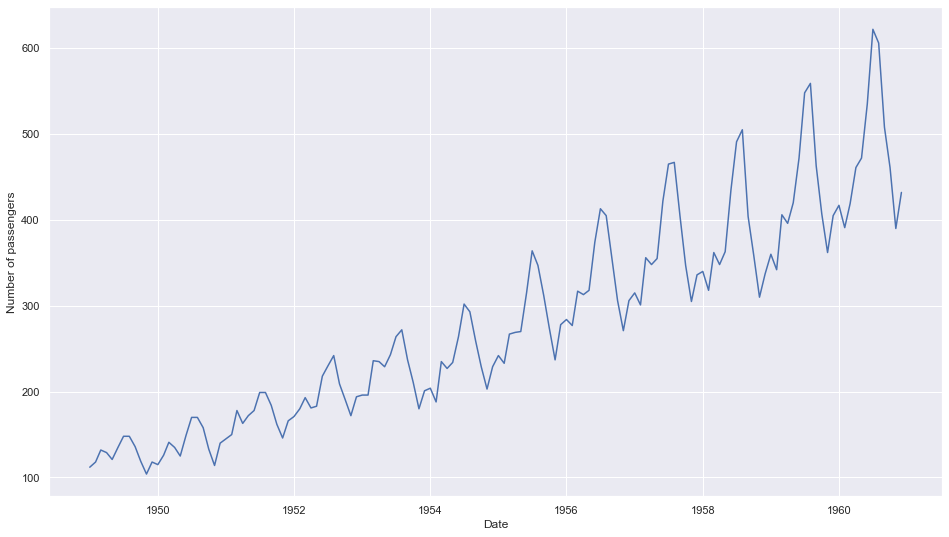

In [16]:
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.plot(series)

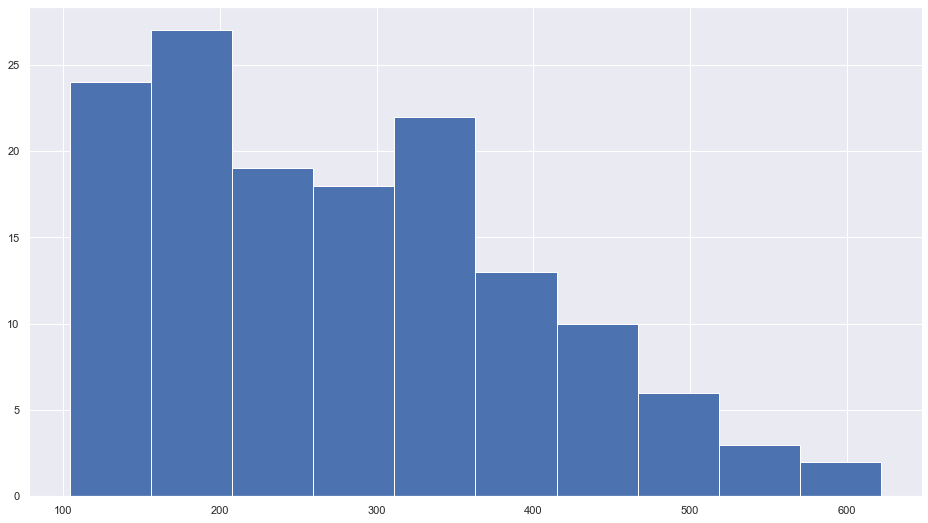

In [17]:
series.hist()
plt.show()

The data shown above has a skew, towards the right. We can make this a normal distribution with some transformation. Now let us make a boxplot:

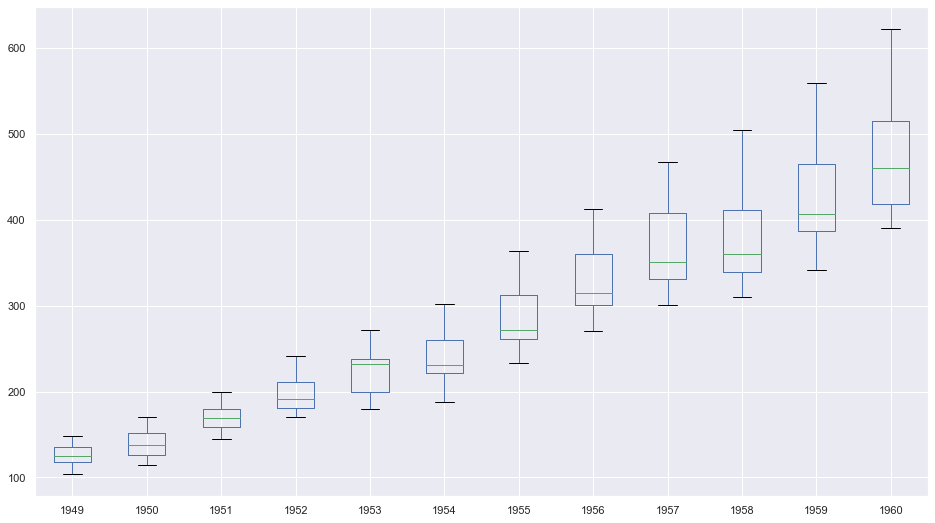

In [18]:
from pandas import DataFrame
from pandas import Grouper
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

## Sliding window

The use of prior time steps to predict the next time step is called the sliding window method. For short, it may be called the window method in some literature.

In statistics and time series analysis, this is called a lag or lag method.

The number of previous time steps is called the **window width or size of the lag**. This sliding window is the basis for how we can turn any time series dataset into a supervised learning problem.

In the above problem, we cannot use the first row because it has NaN.

Sliding Window With Multiple Steps The number of time steps ahead to be forecasted is important. In the example above, we had used one step. There can be multiple steps as well:

1. One-step Forecast: This is where the next time step (t+1) is predicted.

2. Multi-step Forecast: This is where two or more future time steps are to be predicted.

## Rolling Window Statistics

After we have understood lag and sliding window, it is time to focus on rolling window statistics which will be useful for the analysis. One thing that we can do with our data is that we can add a summary of values at previous steps. The summaries could be mean, standard deviation, variation, edian, etc. The most useful will be the rolling mean.

We can calculate the mean of the current and previous values and use that to predict the next value.

In [19]:
temps = DataFrame(series.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
dataframe = concat([means, temps], axis=1)
dataframe.columns = ['mean(t-1,t)', 't+1']
print(dataframe.head(5))

   mean(t-1,t)  t+1
0          NaN  112
1          NaN  118
2        115.0  132
3        125.0  129
4        130.5  121


## Random walk

You pick any time-series from the internet and now you want to forecast it. But, how do you know if that time-series is forecastable or not? There is a tool called a random walk that can help you understand the predictability of your time series forecast problem.

In a random walk, the next value in the sequence is a modification of the previous value in the sequence. The process used to generate the series forces dependence from one-time step to the next. This dependence provides some consistency from step-to-step rather than the large jumps that a series of independent, random numbers provides.

It is this dependency that gives the process its name as a random walk or a drunkard's walk.

## Stationarity of time-series

A stationary time series is one where the values are not a function of time. Given the way that the random walk is constructed and the results of reviewing the autocorrelation, we know that the observations in a random walk are dependent on time. Therefore we can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks.

Stationarity is an important concept in time series analysis. Most forecasting methods assume that a distribution has stationarity. For example, autocovariance and autocorrelations rely on the assumption of stationarity. An absence of stationarity can cause unexpected or bizarre behaviors.

Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time.

Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

#### Models can show different types of stationarity:

1. **Strict stationarity** means that the joint distribution of any moments of any degree (e.g. expected values, variances, third order and higher moments) within the process is never dependent on time. This definition is in practice too strict to be used for any real-life model.

2. **First-order stationarity** series have means that never changes with time. Any other statistics (like variance) can change.

3. **Second-order stationarity** (also called weak stationarity) time series have a constant mean, variance and an autocovariance that doesn’t change with time. Other statistics in the system are free to change over time. This constrained version of strict stationarity is very common.

4. **Trend-stationary models** fluctuate around a deterministic trend (the series mean). These deterministic trends can be linear or quadratic, but the amplitude (height of one oscillation) of the fluctuations neither increases nor decreases across the series.

5. **Difference-stationary models** are models that need one or more differencings to become stationary.

It can be difficult to tell if a model is stationary or not. Sometimes, it can be useful to look at the graphs and tell whether the series is stationary or not using rolling mean and standard deviation, there are other methods that can be used to determine whether a time-series is stationary or not:

1. Unit root tests (e.g. Augmented Dickey-Fuller (ADF) test or Zivot-Andrews test)

2. A KPSS test (run as a complement to the unit root tests).

3. The Priestley-Subba Rao (PSR) Test or Wavelet-Based Test, which are less common tests based on spectrum analysis.

We will be using Augmented Dickey-Fuller test for analyzing if the time-series is stationary or not.

To test if our dataset is stationary or not, we will first make a hypothesis:

1. **H0 or null hypothesis:** The time series is stationary

2. **H1 or alternative hypothesis:** The time series is not stationary

Let us test H0 and assume that the time series is not stationary and now let's visualize the data and perform the Augmented Dickey Fuller test.

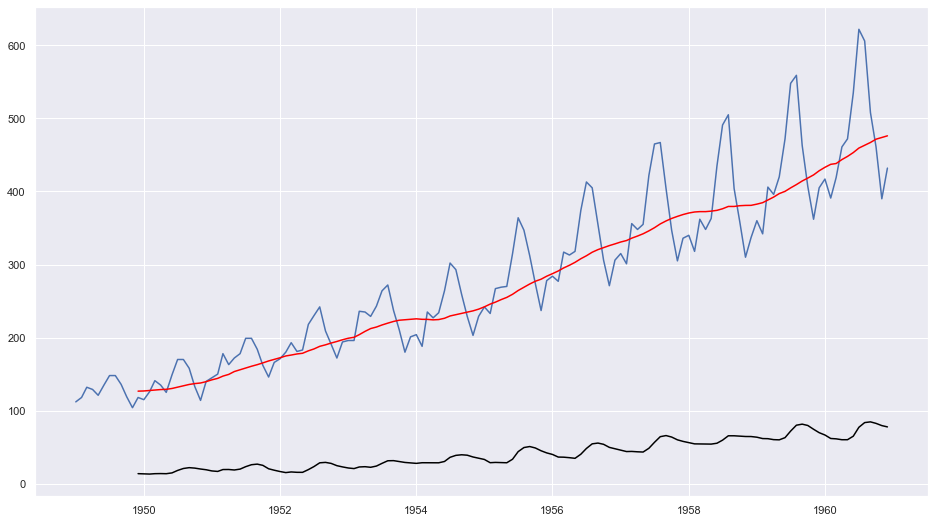

In [20]:
movingaverage=series.rolling(window=12).mean()
movingstd=series.rolling(window=12).std()
plt.plot(series)
plt.plot(movingaverage, color='red')
plt.plot(movingstd, color='black')

We can see that although the standard deviation line is stationary, the moving average line is not stationary. But before rejecting the null hypothesis we will perform Dickey Fuller test as well.

## Augmented Dickey Fuller test

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

We are not interested in the deep technical connotations. We are more concerned about the intuitive understanding behind the ADF test.

The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t). In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

In [21]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(ts):
    
    roll_mean = ts.rolling(window=12).mean()
    movingstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(movingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

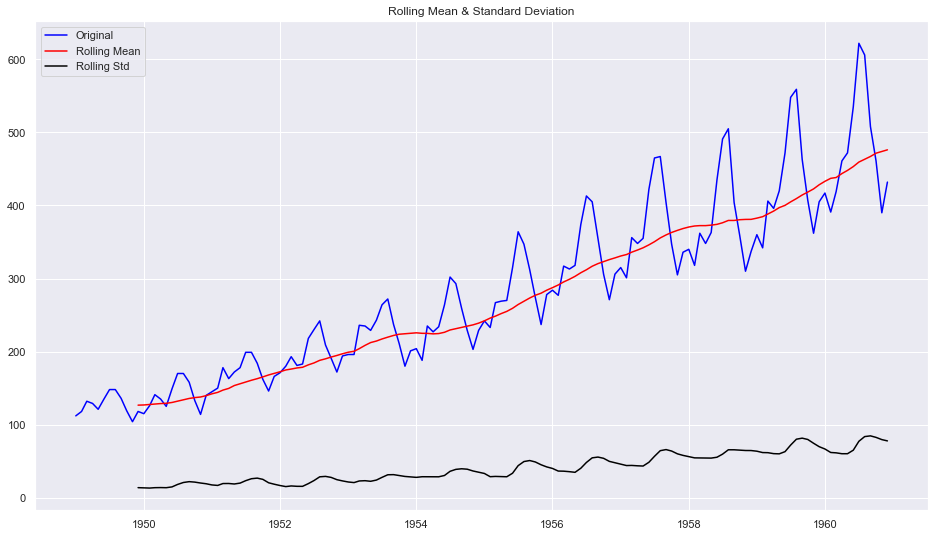

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
stationarity_check(series)

## Time series decomposition

We had discussed that time-series has:

1. **Level:** The average value in the series.

2. **Trend:** The increasing or decreasing value in the series.

3. **Seasonality:** The repeating short-term cycle in the series.

4. **Noise:** The random variation in the series.

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

Decomposition provides a useful abstract model for thinking about time-series generally and for better understanding problems during time series analysis and forecasting.

There are essentially two components in time-series:

1. **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled. They are level, trend and seasonality 

2. **Non-Systematic:** Components of the time series that cannot be directly modeled. This comprises of noise in a time-series.

While some of the series have trend and seasonality, all the time-series have a level and noise. Looking at them individually will help us to make the time-series stationary. The components given above can be in two forms:

**Additive:** Level+Trend+seasonality+ Noise

**Multiplicative:** Level Trend Seasonality * Noise

A multiplicative decomposition is nothing but the sum of logarithmic values of level, trend, seasonality and noise.

While performing decomposition of a time-series, both of these possibilities exist and both need to be tried out. In case of additive model, the relationship is linear and in case of multiplicative is non-linear; can be either quadratic or exponential.

## Why is decomposing a time-series important?

Model data used in practice projects are clean and don't need much modifications but real-world problems are full of trends, seasonality and noise which need to checked before we can make predictions on the time-series at hand. Before performing data preparation or feature selction or even model selection, we need to decompose the time-series. Some of the time-series might not be having consistent trend and can be messy. In such a case, decomposing would still be helpful to give us an idea of what can be done further.

**How do decide which to apply? Additive or multiplicative?**

When you plot the time-series, you will get insights on how the time-series is. The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.

In case of airline passenger dataset, let's try to decompose. Statsmodel library provides us with the naive or the classical method of decomposition. There are other advanced decomposition methods like Seasonal and Trend decomposition using Loess or STL decomposition. We can see that trend varies with the level of the time-series, so we will be using the multiplicative time-series.

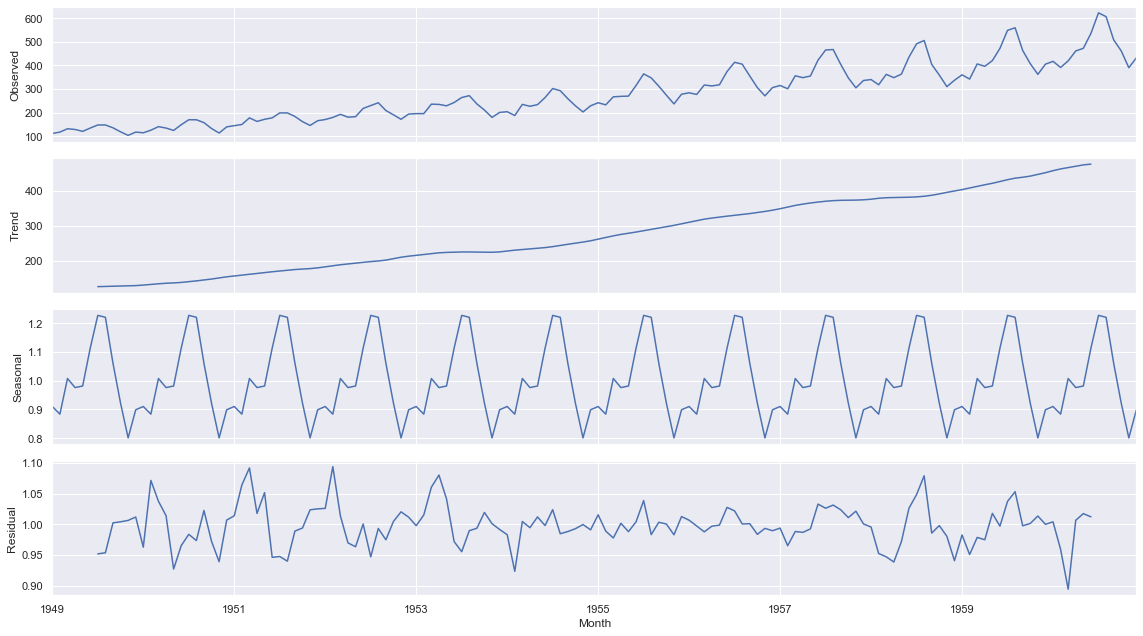

In [23]:
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()

We can clearly see the trend and seasonality in the data. There is also residual or noise in the data which we will further attempt to resolve.

## Removing the trend and seasonality

According to the book, Introductory time-series with R, trend has been defined as a systematic change in a time series that does not appear to be periodic is known as a trend. The trends can be of different types:

Based on locality of time-series:

**Global Trends:** These are trends that apply to the whole time series.

**Local Trends:** These are trends that apply to parts or subsequences of a time series.

Based on the nature of time-series:

**Deterministic Trends:** These are trends that consistently increase or decrease.

**Stochastic Trends:** These are trends that increase and decrease inconsistently.

Perhaps the simplest method to detrend a time series is by differencing. Speciffically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

value(t) = observation(t) - observation(t - 1)

This has the effect of removing a trend from a time series dataset.

Power tranforms Alongwith differencing, a number of power transforms can be used to remove trends, seasonality and noise. There are a number of transforms avaiable and I will be listing some of the popular ones down below:

Square transform Log transform Square root transform Box Cox transform

Let us look the ADF results of the series again:

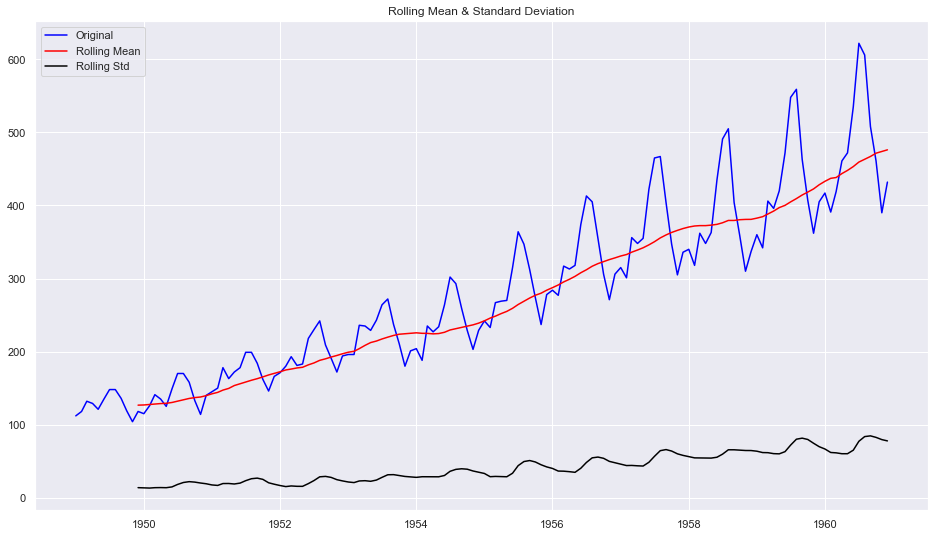

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
stationarity_check(series)

We can only reject null hypothesis when the test statistics is small in a negative number, less than the critical value and p-value is less than 0.05. Only then we can reject our null hypothesis that the series is non-stationary and assume that our time-series is stationary.

I am going to start by performing log transform on the data.

In [25]:
log_series = np.log(series)
log_series.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

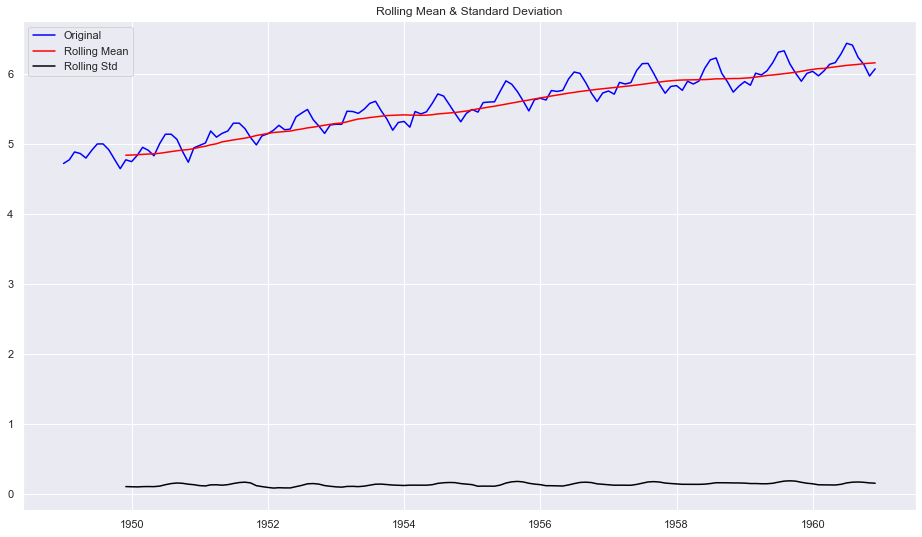

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [26]:
stationarity_check(log_series)

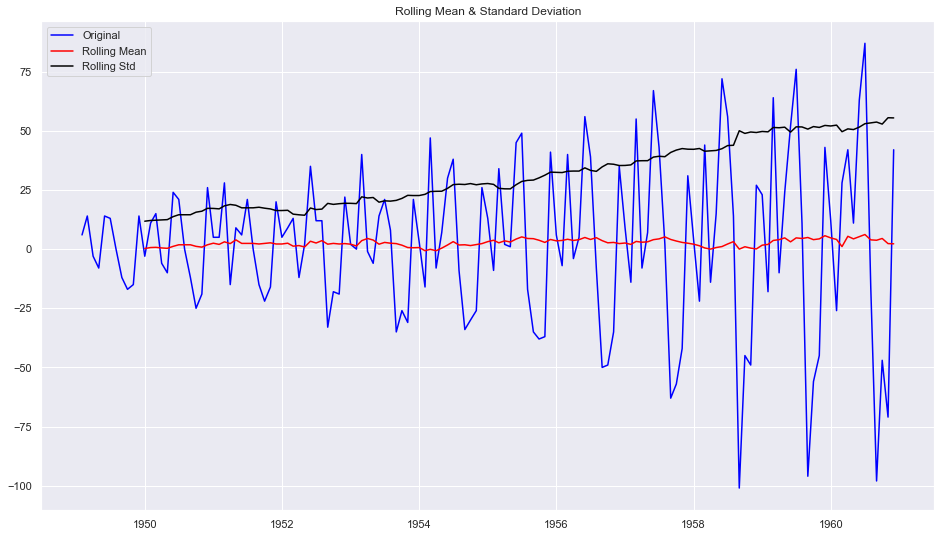

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
series_diff = series.diff()
series_diff = series_diff.dropna()
stationarity_check(series_diff)

Now we will perform differencing on the log transformed data to see how well it performs:

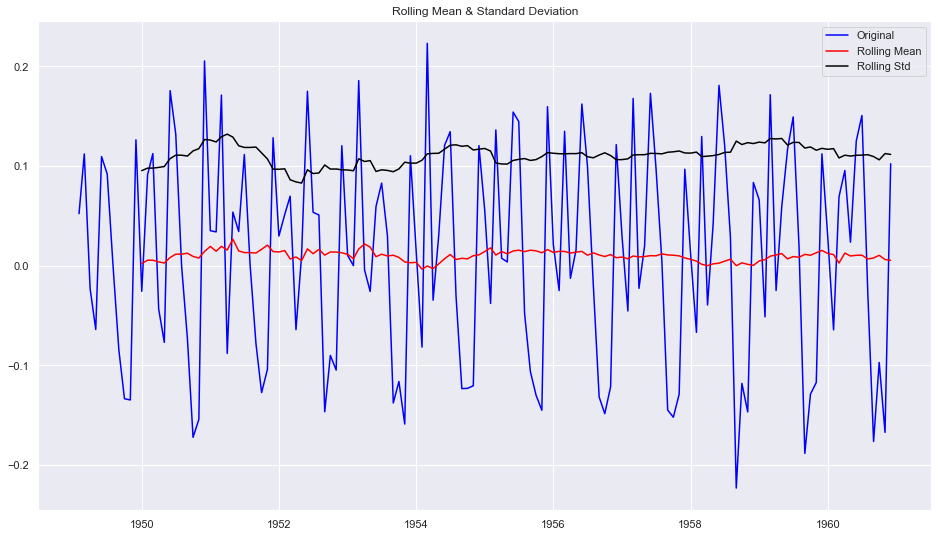

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [28]:
log_series_diff = log_series.diff()
log_series_diff = log_series_diff.dropna()
stationarity_check(log_series_diff)

Let us try one more transformation, i.e. subtracting the moving average from the log transformed series.

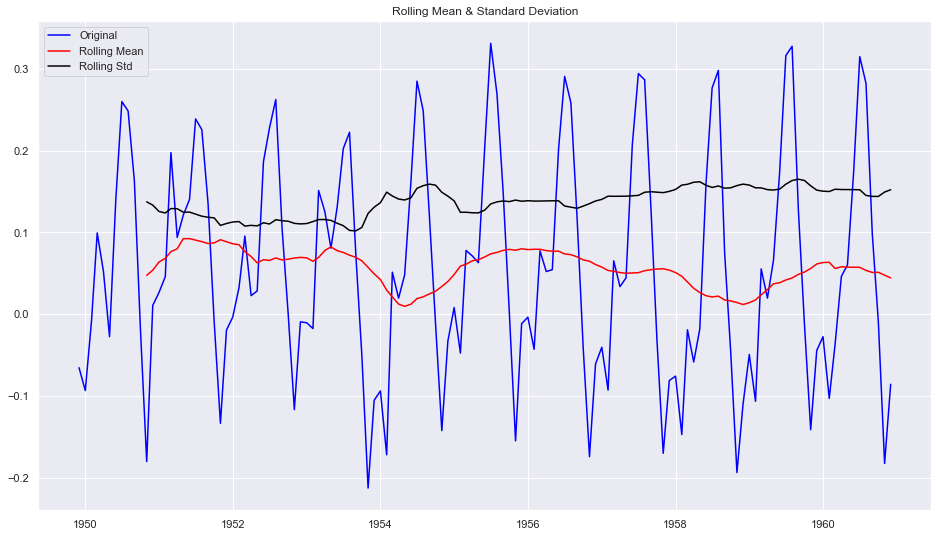

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [29]:
movingAverage = log_series.rolling(window=12).mean()
ma_log_series=log_series-movingAverage
ma_log_series = ma_log_series.dropna()
stationarity_check(ma_log_series)

Test-statistic is not within 1% of the critical value but it is inside the 5% interval and the p-value is quite low. So, this transformation can be used. We can also try time shifts in our time-series

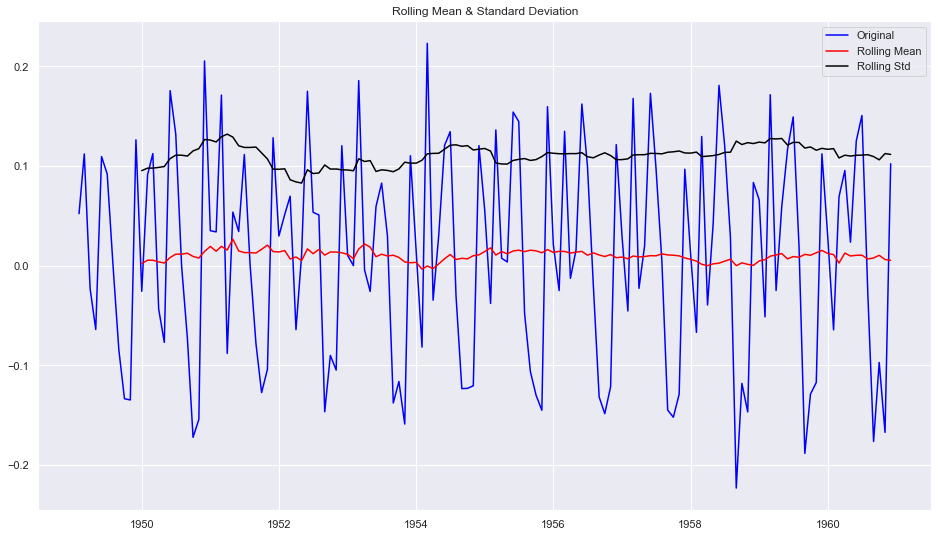

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [30]:
shift_log_series = log_series - log_series.shift()
shift_log_series = shift_log_series.dropna()
stationarity_check(shift_log_series)

## Autocorrelation plots

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1.

The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation. This is similar to the pearson correlation we try to find in our supervised learning problem.

Additionally, Autocorrelation plots are also a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

There are several autocorrelation coefficients, corresponding to each panel in the lag plot. For example, r1 measures the relationship between y(t) and y(t−1),r2 measures the relationship between y(t) and y(t-2), and so on.

### How can the plot be used?

A plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot. A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags. It will resemble a sin curve.

A data with both trend and seasonality will show both of these effects. The ACF will decrease over the period of time and the curve will pulse while decreasing.

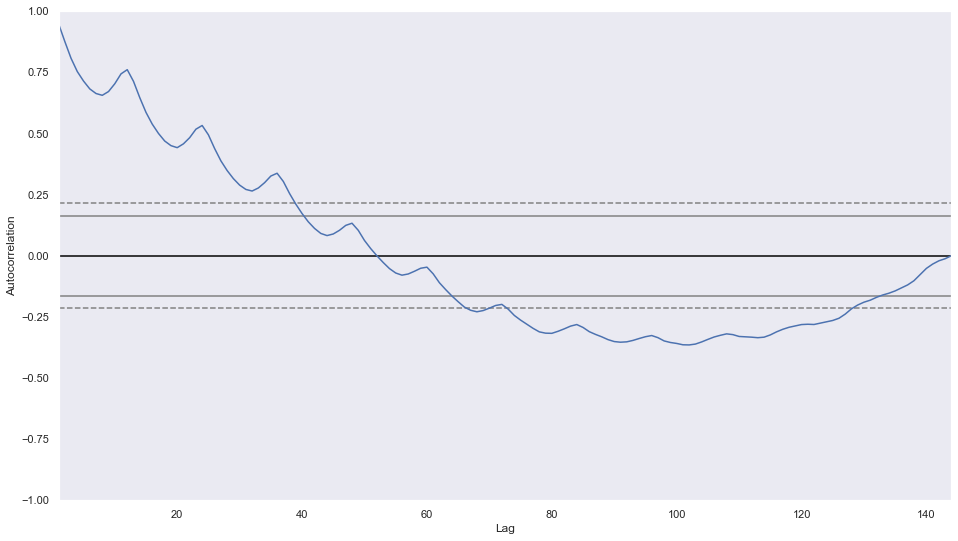

In [31]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

The plot above shows strong correlation, a positive relationship between the variable and the initial few values of lags. If this plot was a sin curve, it will indicate strong seasonality in the data. The graph above clearly shows trend in the data.

## Partial Autocorrelation plots

In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables.

For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2. This partial correlation can be computed as the square root of the reduction in variance that is achieved by adding X3 to the regression of Y on X1 and X2.

NOTE: If this sounds overwhelming, please watch the video I am linking down below to understand better:

Link to the video: https://www.youtube.com/watch?v=5Q5p6eVM7zM

## ARIMA model

I have directly picked this from the blog Machine learning mastery

An ARIMA model is a class of statistical model for analyzing and forecasting time series data. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

**AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I:** Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA:** Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.

**d:** The number of times that the raw observations are differenced, also called the degree of differencing.

**q:** The size of the moving average window, also called the order of moving average.

The method described above is decsribed as Box-Jenkins, devleoped by George Box and Gwilym Jenkins. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

The next question that comes here is, how do we find out the values of p,d and q? It is usually based on the intuitions derived from the ACF and PACF plots. It is more of a hit and trial process wherein we guess the values to be kept in p and q.

### Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

### Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

I am going to show the above things in our air passenger dataset and it will be clearer.

I am going to be using the data that we obtained by differencing the time-series once. The code below is to plot the ACF and PACF plots.

Note that we will be using log_series_diff. Logging a time series straightens out the exponential growth patterns and reduces the variance. Although it does not eliminate the upward trend in the data, it can deflate the trend so that it can be better fitted by a ARIMA model. Differencing is an explicit option in ARIMA models. To show the percentage change in the time series, the first difference of log is used. Hence, the plot has been drawn on log_series_diff. Notice the y-axis units on your plot, it will be % change in value.

In [32]:
def acfpacf(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

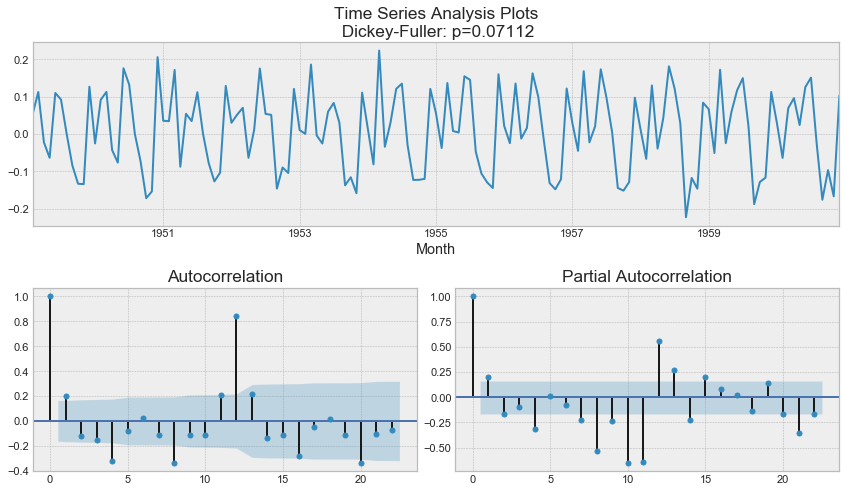

In [33]:
acfpacf(log_series_diff)

Now, for finidng the value of AR, the p, we will look at the PACF plot on thr right and try to look at the point where the PACF shuts off which means where we see drastic drop in the PACF plot and it happens after 1 so the value of p can be taken between 1-2. For convenience, we will take 1.

Now, the q value will be where we see exponential decrease in the ACF plot. We are not looking for a drastic change, we are rather looking for a curve that turns asymptotic. We can see that happening after 1. Now, we will look at where these changes, related to both p and q happen for the first time.

If the above text doesn't make much sense, we will try another acf pacf plot which gives us more information about choosing p and q. The above one is good to determine the confidence intervals. The method discussed below will be used to determine the values of p and q at a glance.

C:\Users\srtpa\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


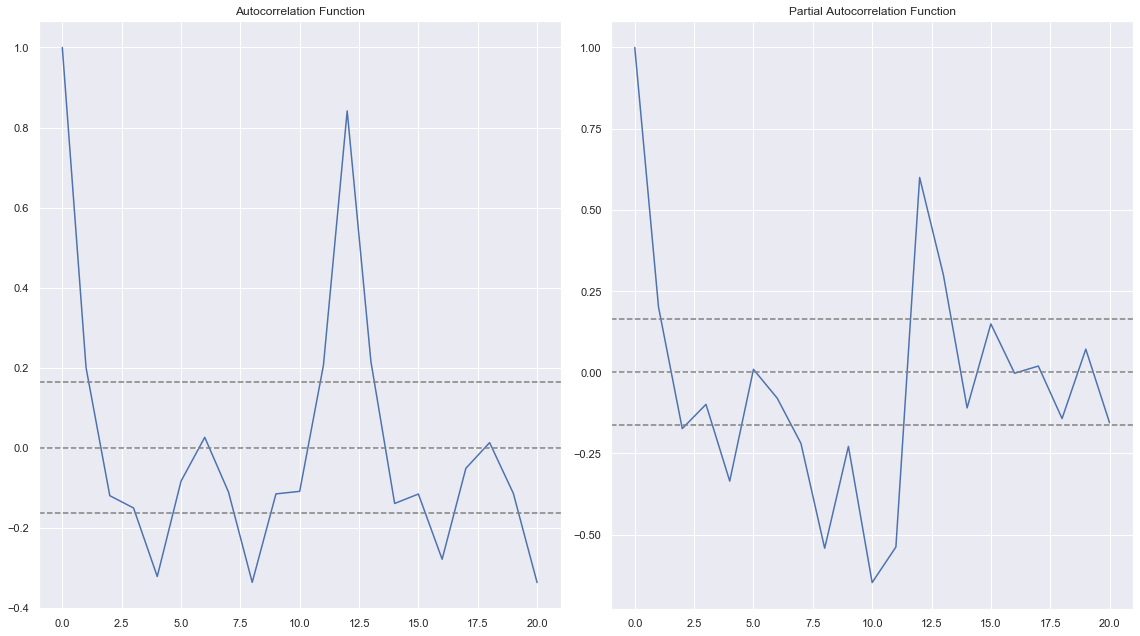

In [34]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(log_series_diff, nlags=20)
lag_pacf = pacf(log_series_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

In the above graphs, we only have to see when the acf and pacf plot cuts the baseline for the first time. In the case od p, to be taken from the pacf plot, the value is somewhere between 1-2 and the same for q. Let us try the value of 1 first:

C:\Users\srtpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\srtpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Fri, 24 Jul 2020   AIC                           -241.608
Time:                        15:30:55   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.D.#Passengers    -0.5826      0.128     -4.536      0.000      -0.834      -0

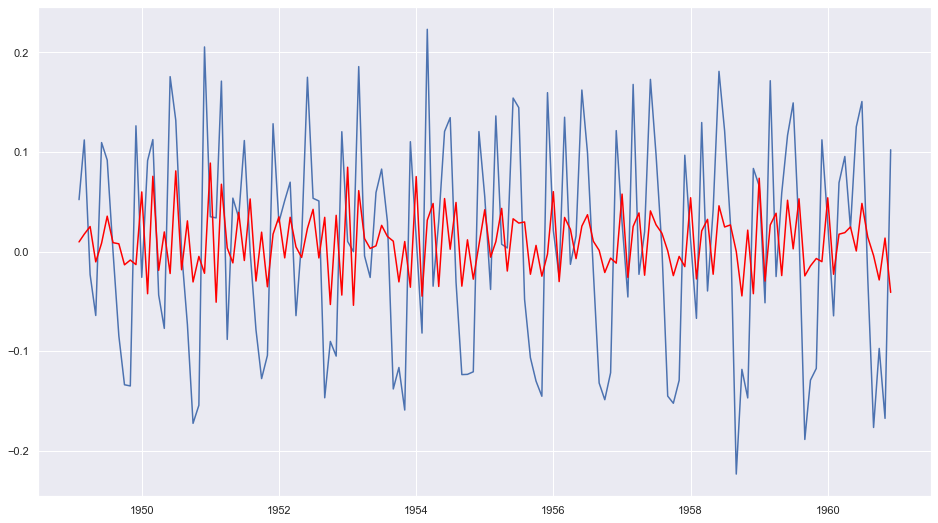

In [35]:
model = ARIMA(log_series, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

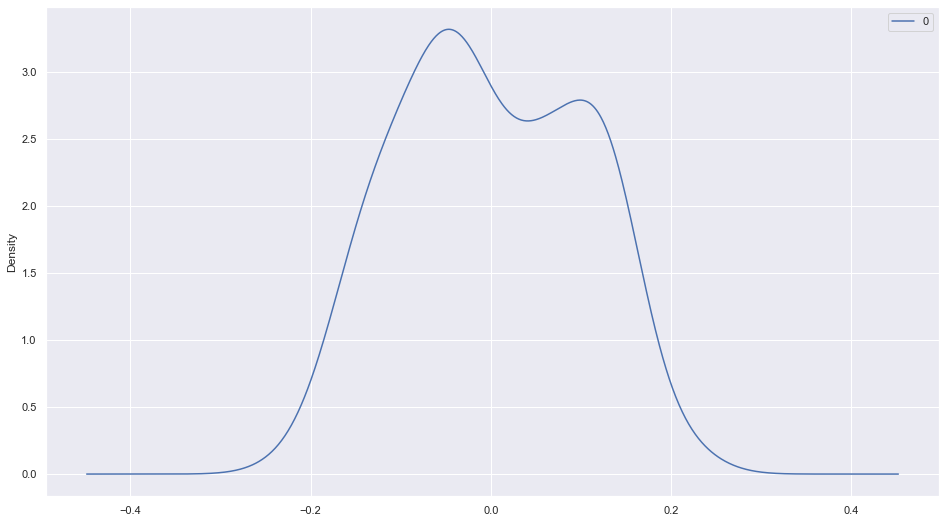

In [36]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()


In [37]:
print(residuals.describe())

                0
count  143.000000
mean    -0.000026
std      0.101389
min     -0.223351
25%     -0.078643
50%     -0.009057
75%      0.089547
max      0.227127


Let us 2,2 as the p,q values and see the results

C:\Users\srtpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\srtpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Fri, 24 Jul 2020   AIC                           -287.281
Time:                        15:34:37   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1

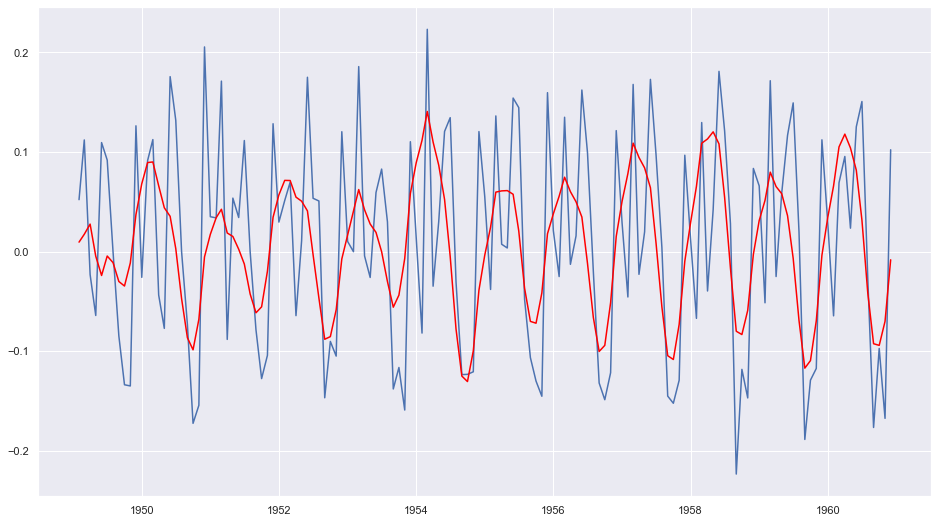

In [38]:
model = ARIMA(log_series, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

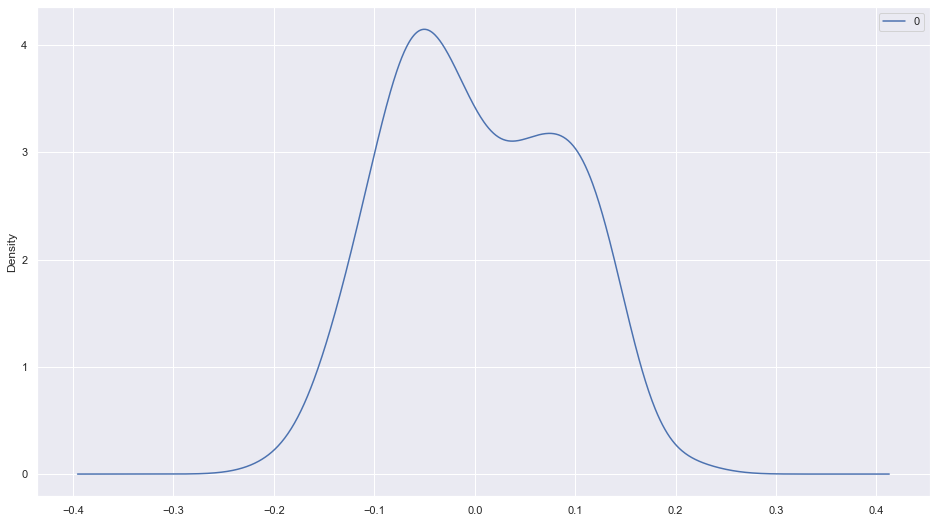

In [39]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [40]:
print(residuals.describe())

                0
count  143.000000
mean     0.001691
std      0.085116
min     -0.193387
25%     -0.063327
50%     -0.005020
75%      0.074606
max      0.210671


We can see from the fit of the model and residual details that model with p and q both as 2, performs better.

## Forecast using ARIMA model

The ARIMA model can be used to forecast future time steps. We can use the predict() function on the ARIMAResults object4 to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

Now there are two methods in which the predictions can be made, one is to use test and train and compare the predictions with the test data. The second is to use the sntire data and compare the predictions with the original data. You can use either of these. I am going to show the elaborate method of using the netire data and how can we predict on the original dataset after reverting all the transformations we have made till now. This makes it easier to compare and visualize.

In [41]:
pred = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(pred.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Using the codes above, we have the predicted values. Now it is time to revert the transformations we had made to make our series stationary.

First, we find cumulative sums of all the elements in our series as we have differneced our time series.

In [42]:
pred_sum = pred.cumsum()
print(pred_sum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280202
1960-10-01    1.186189
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


What we have seen above is the differences, or the delta, but we need the absolute values too. So, we will start all these delta to the first value on the time series to get the log series.

In [43]:
pred_log = pd.Series(log_series.iloc[0], index=log_series.index)
pred_log = pred_log.add(pred_sum, fill_value=0)
pred_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

We have the log of our time series, now it is time to find exponential values to remove the log.

if x=log(y),

in order to find y,

y=e^x. We will be doing the same:

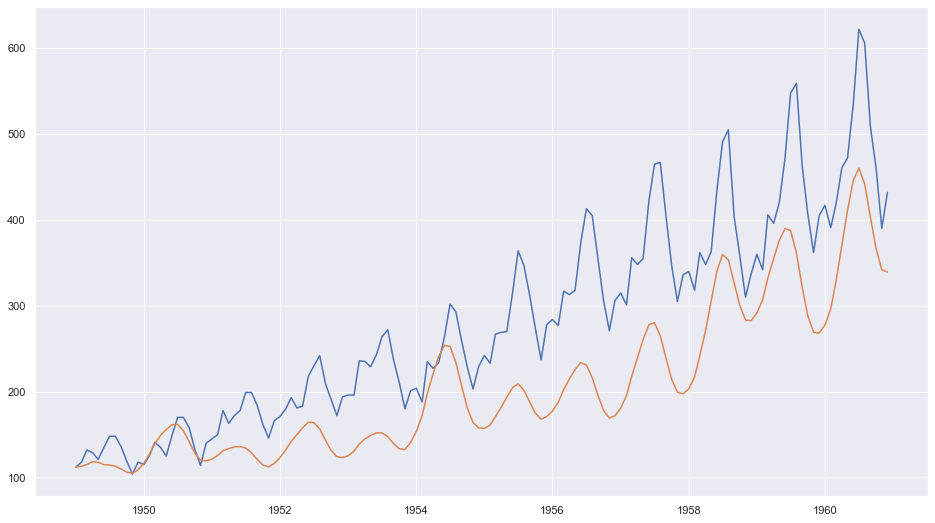

In [44]:
final_pred = np.exp(pred_log)
plt.plot(series)
plt.plot(final_pred)